### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [**`make_classification`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [14]:
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.3f}'.format
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import make_classification
from BetaCalibrator import *

In [2]:
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 20, 
                           n_informative = 15, 
                           n_redundant   = 5, 
                           random_state  = 0, 
                           shuffle       = False, 
                           n_classes     = 2, 
                           weights       = [0.9, 0.1])

X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) 
                             for n in range(1,X.shape[1]+1)]) 

Split **X** and **y** into random train and test subsets.

In [3]:
tts_kwds = {"test_size"   : 0.3,
            "random_state": 0, 
            "shuffle"     : True}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwds)

Train model with **train** set.

In [4]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 200, 
            "n_jobs"      : -1, 
            "class_weight": "balanced", 
            "max_depth"   : 7, 
            "max_features": "sqrt"})

clf.fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

### <font color="green" size=5> Calibration of probability </font>

The purpose of [`calibration`](https://scikit-learn.org/stable/modules/calibration.html)  is to improve estimated probabilities, which can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a **`predict_proba`** value close to 0.8, approx. 80% actually belong to the positive class.

**<font color="black" size=3> What is Beta Calibration? </font>**

Beta Calibration is an advanced post-processing calibration technique that transforms a model’s predicted probabilities into better-calibrated probabilities. It was introduced by Kull, Filho, and Flach (2017) as a generalization of Platt’s scaling, providing more flexibility by modeling the calibrated probabilities with a Beta distribution rather than a simple logistic function.

- Platt scaling $$p=\sigma(a⋅s+c)$$
- Beta Calibration $$p=\sigma(a⋅\log(s)+b⋅\log(1−s)+c)$$

where:
- $s$ is an uncalibrated model score $s\in[0,1]$
- $a,b,c$ are parameters to be learned
- $\sigma(x) = \frac{1}{1+e^{-x}}$ is the logistic function

---

**<font color="black" size=3> Type of Beta Calibrations </font>**

1. ABM (Full Beta Calibration)
    - All three parameters are used: $a,b,c$
    - Most flexible and can correct both skew and miscalibration near 0 or 1
    - a &rightarrow; Coefficient for $\log(s)$
    - b &rightarrow; Coefficient for $\log(1-s)$
    - c &rightarrow; Intercept
    - $p=\sigma(a⋅\log(s)+b⋅\log(1−s)+c)$

2. AM (A + Intercept)
    - Only $a$ and $c$ are learned while $b$ is fixed
    - a &rightarrow; Coefficient for $\log(\frac{1}{(1 -s)})$
    - b &rightarrow; a
    - c &rightarrow; Intercept
    - $p=\sigma(a⋅\log(\frac{1}{(1 -s)})+c)$
    
3. AB (No Intercept)
    - Only $a$ and $b$ are learned while $c$ is 0.
    - a &rightarrow; Coefficient for $\log(s)$
    - b &rightarrow; Coefficient for $\log(1-s)$
    - c &rightarrow; 0.
    - $p=\sigma(a⋅\log(s)+b⋅\log(1-s))$

**<font color="blue" size=4> Example 1: Beta Calibration using ABM Method </font>**

The following example demonstrates how to apply Beta Calibration using the "abm" method, where parameters _`a`_, _`b`_, _`c`_, and _`m`_ are learned from data.

<div style="padding:10px; border-left:5px solid #f39c12; background-color:#fff8e1;">
    <b>Note:</b> The calibration model must be fitted on a dataset that is <b>independent</b> from the one used to train the classifier.<br> Using the same samples can lead to <b>biased calibration</b>.
</div>

**<font color="black" size=4> 1. Model Training and Calibration </font>**

In [5]:
# Initialize Beta Calibration model using "abm" method
abm_model = BetaCalibration("abm")

# Fit the calibrator using predicted probabilities and true labels
abm_model.fit(y_test_proba, y_test)

BetaCalibration(estimator=LogisticRegression(C=1000000000000.0, max_iter=9988))

**<font color="black" size=4> 2. Calibrator Parameters  </font>**

The Beta Calibration model estimates four parameters:
_`a`_, _`b`_, _`c`_, and _`m`_, where _`m`_ represents the inflection point of the calibration curve.

In [6]:
abm_model.params_

Parameters(a=0.0, b=9.450428924205301, c=-7.004744714052172, m=0.5234631677981932)

**<font color="black" size=4> 3. Pre- and Post-Calibration Performance </font>**

You can view the Brier score and log-loss before and after calibration.

In [7]:
abm_model.losses_

Losses(brier_score=[0.08803823472690542, 0.03780771047320076], log_loss=[0.33208460489803954, 0.14057148029726366], ece_score=[0.21338749414070945, 0.006999031753615903])

<div style="padding:10px; border-left:5px solid #3498db; background-color:#ebf5fb;">
    <b>Info:</b> Lower post-calibration losses indicate that the calibrated probabilities better reflect true likelihoods.
</div>

Use the line below to <b>evaluate the calibration performance</b> of your model on other data:

In [8]:
abm_model.evaluate(y_train_proba, y_train)

Losses(brier_score=[0.07360912907420548, 0.018248208951888122], log_loss=[0.2972692421638243, 0.0728135471113714], ece_score=[0.22327042460781918, 0.018488142178215365])

**<font color="black" size=4> 4. Visualization and interpretation</font>**

Use the line below to <b>visualize calibration performance</b> using both calibration and reliability curves.

In [9]:
# Initialize the calibration metrics class
visualize = calibration_metrics(abm_model, alpha=0.05, bins=10, strategy="linear")
visualize.fit(y_test, y_test_proba)

**<font color="black" size=4> 4.1 Calibration Curve </font>** 

The calibration curve shows how closely the predicted probabilities match the actual outcomes.

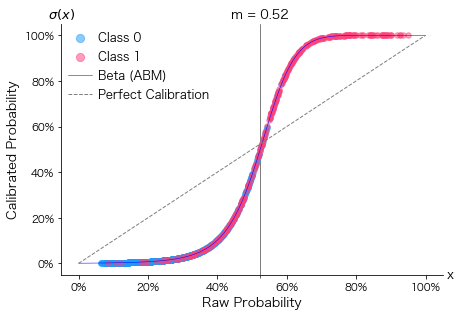

In [10]:
ax = visualize.calibration_curve(y_test, y_test_proba)

This produces the following calibration curve:

- The **dotted diagonal line** represents **perfect calibration**, where predicted probabilities match actual outcomes.
- The **blue line** shows the calibrated curve.
- The **points** represent the actual class outcomes.
- The **vertical line** marks **the inflection point** — where the calibration function transitions most steeply.

<div style="
    border-left: 5px solid #00b894;
    background-color: #ecfdf5;
    padding: 10px 15px;
    border-radius: 5px;
    font-family: 'Segoe UI', sans-serif;
">
💡 <b>Tip:</b>
To focus on a single class, apply a mask to your data before plotting:
<pre><code>self.plot(y_proba[y_true==1], y_true[y_true==1])</code></pre>
This displays the calibration curve only for samples belonging to <b>Class 1</b>.
</div>

**<font color="black" size=4> 4.2 Interpretation of Calibration Curve </font>**

- When the calibrated curve is **below** the diagonal, the model is **overconfident** (it predicts probabilities that are too high).
- When it is **above** the diagonal, the model is **underconfident**.
- _`m`_ indicates the point of steepest change, acting as the inflection point that shapes the calibration mapping.

**<font color="black" size=4> 4.3 Reliability Curve </font>** 

The reliability curve provides a statistical summary of calibration error across bins, including confidence intervals.

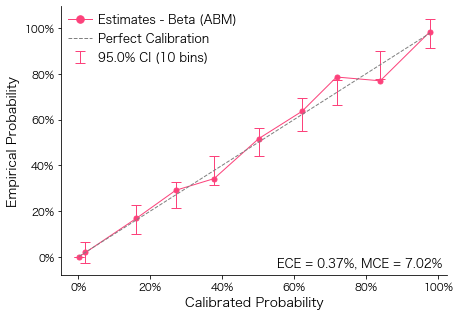

In [11]:
ax = visualize.reliability_curve(y_test, y_test_proba)

This produces the following reliability curve:

- The **dotted diagonal line** represents **perfect calibration**, where calibrated probabilities match empirical outcomes.
- The **pink markers** represents empirical probabilities (observed outcomes) versus predicted probabilities.
- The **error bars** denotes the confidence intervals across bins.
- **ECE (Expected Calibration Error)** and **MCE (Maximum Calibration Error)** summarize the overall and worst-case deviations from perfect calibration, respectively.

Mathematically:
$$ECE =\sum_{i=1}^{N} \frac{n_{i}}{N} \|acc(B_{i}) - conf(B_{i})\|$$
$$MCE= max_{i\in\{1,...,K\}} \|acc(B_{i}) - conf(B_{i})\|$$

Where:
- $K$: number of bins
- $n_{i}$: number of samples in bin 
- $N$: total number of samples
- $acc(B_{i})$: average empirical accuracy in bin $i$
- $conf(B_{i})$: average predicted confidence in bin $i$

**<font color="black" size=4> 4.4 Interpretation of Reliability Curve </font>**

- When the reliability curve is **below** the diagonal, the calibrated model **underestimates** probabilities. 
- When it is **above** the diagonal, the model **overestimates** probabilities.
- The error bars show the variability or uncertainty (confidence interval) of the empirical estimates across bins.

**<font color="blue" size=4> Example 2: Comparison of all Beta-calibration methods </font>**

In [12]:
# Initialize Calibration models
methods = {"Beta (ABM)": BetaCalibration("abm"),
           "Beta (AB)" : BetaCalibration("ab"),
           "Beta (AM)" : BetaCalibration("am"), 
           "Logistic"  : BetaCalibration("sigmoid")}

results = []

# Fit all calibrators and record parameters and metrics
for name, calibrator in methods.items():
    
    # Fit calibrator on test set
    calibrator.fit(y_test_proba, y_test)
    
    # Record parameters (a, b, c, m)
    params = calibrator.params_._asdict()
    data = {"Method": name, **params}
    
    # Evaluate performance on Test and Train sets
    loss_test  = calibrator.losses_._asdict()
    loss_train = calibrator.evaluate(y_train_proba, y_train)._asdict()

    # Add to result list
    data.update({f"{k}_Test": v[1] for k,v in loss_test.items()})
    data.update({f"{k}_Train": v[1] for k,v in loss_train.items()})
    results.append(data)

# MultiIndex columns
columns = [("Method", "") if key == "Method" else
           ("Parameters", key) if len(key)==1 else
           ("_".join(key.split("_")[:-1]), key.split("_")[-1])
           for key in data.keys()]

df = pd.DataFrame(results)
df.columns = pd.MultiIndex.from_tuples(columns)
df = df.sort_index(axis=1, level=0)

In [13]:
df

Method Parameters                     brier_score       ece_score  \
                       a      b      c     m        Test Train      Test   
0  Beta (ABM)      0.000  9.450 -7.005 0.523       0.038 0.018     0.007   
1   Beta (AB)      4.091  3.631  0.000 0.521       0.038 0.019     0.014   
2   Beta (AM)      3.861  3.861 -0.359 0.523       0.038 0.019     0.011   
3    Logistic     16.882 16.882 -8.768 0.519       0.038 0.019     0.009   

        log_loss        
  Train     Test Train  
0 0.018    0.141 0.073  
1 0.023    0.145 0.075  
2 0.022    0.145 0.075  
3 0.021    0.142 0.074